In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import country_converter as coco
import pypsa

import cartopy
import cartopy.crs as ccrs

In [2]:
import cartopy.feature as cfeature

In [4]:
import re

In [5]:
import seaborn as sns

In [6]:
n3=pypsa.Network(r"./elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc")

INFO:pypsa.io:Imported network elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


<Figure size 6000x1500 with 0 Axes>

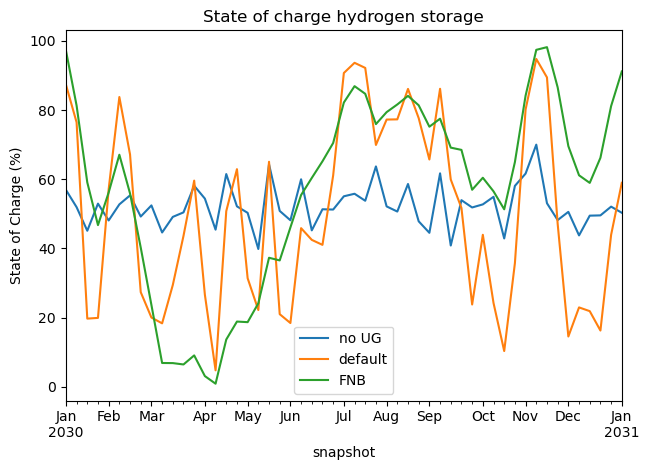

<Figure size 640x480 with 0 Axes>

In [150]:
plt.figure(figsize=(20,5), dpi = 300)
pct.resample("W").mean().plot()
plt.title('State of charge hydrogen storage')
plt.tight_layout()
plt.ylabel('State of Charge (%)')
plt.show()


In [29]:
def plot_dispatch(n, time):
    
    #p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3) # in Europe
    p_by_carrier = n.generators_t.p.filter(regex='^DE').groupby(n.generators.carrier, axis=1).sum().div(1e3) # in Germany

    p_by_carrier_modified = p_by_carrier.copy()

    # Sum columns that start with "offwind"
    offwind_cols = [col for col in p_by_carrier.columns if col.startswith('offwind')]
    p_by_carrier_modified['offwind'] = p_by_carrier[offwind_cols].sum(axis=1)

    # Sum columns that end with "solar thermal"
    solar_thermal_cols = [col for col in p_by_carrier.columns if col.endswith('solar thermal')]
    p_by_carrier_modified['solar thermal'] = p_by_carrier[solar_thermal_cols].sum(axis=1)

    # Drop the original "offwind" and "solar thermal" columns
    p_by_carrier_modified.drop(columns=offwind_cols + solar_thermal_cols, inplace=True)
    p_by_carrier_modified.index = pd.to_datetime(p_by_carrier_modified.index)
    p_by_carrier_modified.index = p_by_carrier_modified.index.map(lambda dt: dt.replace(year=2030))
    
    if not n.stores.empty:
        #sto = n.stores_t.p.groupby(n.stores.carrier, axis=1).sum().div(1e3) # in Europe
        sto = n.stores_t.p.filter(regex='^DE').groupby(n.stores.carrier, axis=1).sum().div(1e3) # in Germany

        sto_modified = sto.copy()

        # Sum columns that end with "water tanks"
        water_tanks_cols = [col for col in sto.columns if col.endswith('water tanks')]
        sto_modified['water tanks'] = sto[water_tanks_cols].sum(axis=1)

        # Drop the original "water tanks" columns
        sto_modified.drop(columns=water_tanks_cols, inplace=True)

        sto_modified = sto_modified.rename(columns={"battery storage":"battery"})
        sto_modified = sto_modified.rename(columns={"home battery":"battery"})
        sto_modified.index = pd.to_datetime(sto_modified.index)
        sto_modified.index = sto_modified.index.map(lambda dt: dt.replace(year=2030))

        p_by_carrier_modified = pd.concat([p_by_carrier_modified, sto_modified], axis=1)
    
    fig, ax = plt.subplots(figsize=(15, 8))

    color = {
        "battery": "#ace37f",
        #"EV battery": '#ace37f', 
        "H2 Store": '#bf13a0',
        "biogas": '#e3d37d',
        "co2": '#f29dae',
        "co2 stored": '#f2385a',
        #"home battery": '#80c944',
        "oil": '#c9c9c9',
        "solid biomass": '#baa741',
        "gas": '#e05b09',
        "water tanks": '#e69487',
        "methanol": '#468c8b',

        "solar": '#f9d002',
        "solar rooftop": '#ffea80', 
        "onwind": '#235ebc',
        "offwind": '#6895dd',
        "ror": '#3dbfb0',
        "solar thermal": '#ffbf2b',

    }
    
    #n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k')
    
    p_by_carrier_modified.where(p_by_carrier_modified>0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )
    
    charge = p_by_carrier_modified.where(p_by_carrier_modified<0).dropna(how='all', axis=1).loc[time]

    if not charge.empty:

        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
            
        )
    
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k')

    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1,1), ncol=10)
    ax.legend(handles=handles[::-1], labels=labels[::-1], loc='upper center', bbox_to_anchor=(-3.2, 1.25), ncol=5)
    plt.legend(loc='upper center', bbox_to_anchor=(0, 1.25))
    #plt.legend(loc=(1.05,0))
    ax.set_ylabel("GW")
    ax.set_ylim(-10, 20)

In [27]:
color_list = pd.DataFrame(n3.carriers.color)
color_list

color
Carrier                                     
AC                                   #70af1d
DC                                   #8a1caf
offwind-ac                           #6895dd
offwind-dc                           #74c6f2
solar                                #f9d002
...                                      ...
agriculture machinery oil emissions  #333333
land transport oil                   #afafaf
low-temperature heat for industry    #8f2727
agriculture heat                     #d9a5a5
low voltage                          #97ad8c

[117 rows x 1 columns]

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_45085/1976511035.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.filter(regex='^DE').groupby(n.generators.carrier, axis=1).sum().div(1e3) # in Germany
/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_45085/1976511035.py:23: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sto = n.stores_t.p.filter(regex='^DE').groupby(n.stores.carrier, axis=1).sum().div(1e3) # in Germany


ValueError: Invalid color nan

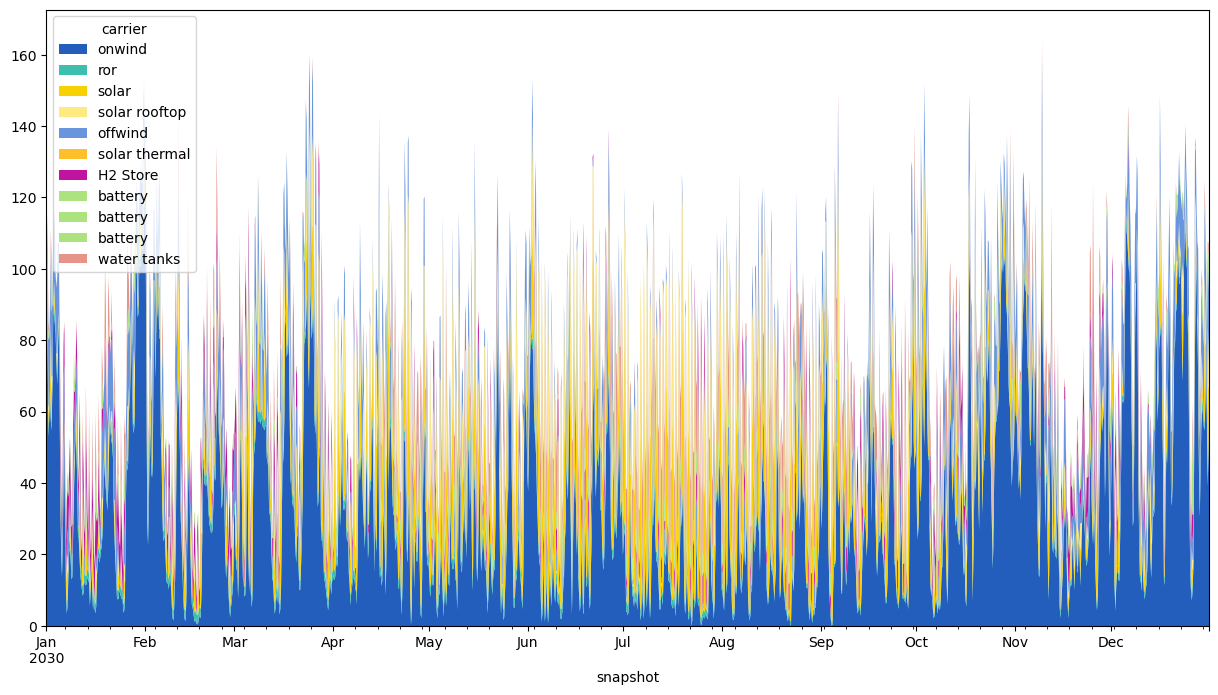

In [30]:
plot_dispatch(n3, time="2030")

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_6800/2155092378.py:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_6800/2155092378.py:23: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



ValueError: Invalid color nan

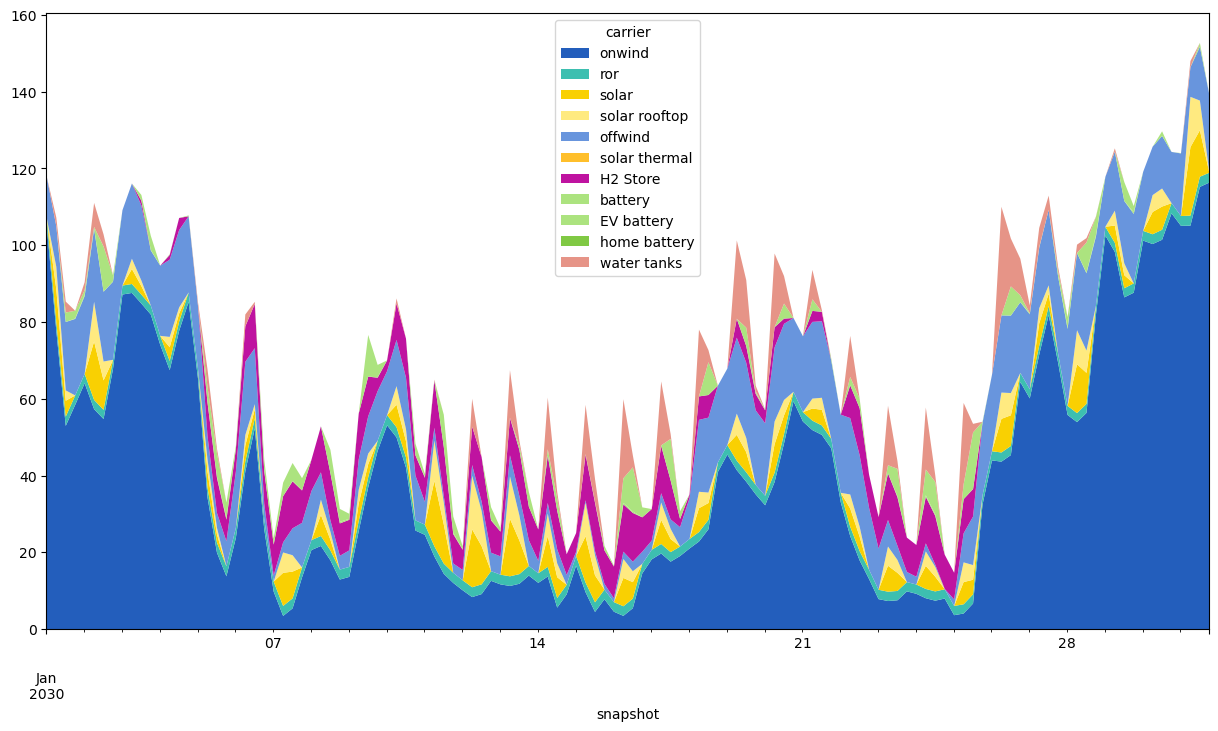

In [194]:
plot_dispatch(n3, time="2030-01")

In [31]:
wind2=n3.generators_t.p.filter(like='wind').filter(like="DE").div(1e3).sum(axis=1)
solar2=n3.generators_t.p.filter(like='solar').filter(like="DE").div(1e3).sum(axis=1)
ror2=n3.generators_t.p.filter(like='ror').filter(like="DE").div(1e3).sum(axis=1)

load2=n3.loads_t.p_set.filter(like="DE").div(1e3).sum(axis=1)
h2_demand2=n3.loads_t.p.filter(like="H2").filter(like="DE").div(1e3).sum(axis=1)
h2_supply2=n3.links_t.p1.filter(like="H2").filter(like="DE").div(1e3).sum(axis=1)

h2_dispatch2=n3.stores_t.p.filter(like="H2").filter(like="DE").div(1e3).sum(axis=1)
h2_store_level2=n3.stores_t.e.filter(like="H2").filter(like="DE").div(1e3).sum(axis=1)
h2_store_max2=n3.stores.e_nom_opt.filter(like="H2").filter(like="DE").div(1e3).sum()
h2_SOC2=h2_store_level2/h2_store_max2*100

battery_dispatch2=n3.stores_t.p.filter(like="battery").filter(like="DE").div(1e3).sum(axis=1)# GW
battery_level2=n3.stores_t.e.filter(like="battery").filter(like="DE").div(1e3).sum(axis=1)
battery_max2=n3.stores.e_nom_opt.filter(like="battery").filter(like="DE").div(1e3).sum()
battery_SOC2=battery_level2/battery_max2*100

watertank_dispatch2=n3.stores_t.p.filter(like="water tanks").filter(like="DE").div(1e3).sum(axis=1)# GW
watertank_level2=n3.stores_t.e.filter(like="water tanks").filter(like="DE").div(1e3).sum(axis=1)
watertank_max2=n3.stores.e_nom_opt.filter(like="water tanks").filter(like="DE").div(1e3).sum()
watertank_SOC2=watertank_level2/watertank_max2*100


hydro_dispatch2=n3.storage_units_t.p.filter(like="hydro").filter(like="DE").div(1e3).sum(axis=1)# GW
hydro_level2=n3.storage_units_t.state_of_charge.filter(like="hydro").filter(like="DE").div(1e3).sum(axis=1)
hydro_max2=hydro_level2.max()
hydro_SOC2=hydro_level2/hydro_max2*100

PHS_dispatch2=n3.storage_units_t.p.filter(like="PHS").filter(like="DE").div(1e3).sum(axis=1)# GW
PHS_level2=n3.storage_units_t.state_of_charge.filter(like="PHS").filter(like="DE").div(1e3).sum(axis=1)
PHS_max2=PHS_level2.max()
PHS_SOC2=PHS_level2/PHS_max2*100

In [46]:
# create time series dataframe in Germany for case FNB
ts2 = pd.DataFrame(wind2)
ts2 = ts2.rename(columns={0:'wind [GW]'})
ts2["solar [GW]"] = solar2
ts2["ror [GW]"] = ror2
ts2["load [GW]"] = load2
ts2["h2 demand [GW]"] = h2_demand2
ts2["h2 supply [GW]"] = h2_supply2
ts2["h2 dispatch [GW]"] = h2_dispatch2
ts2["h2 SOC [%]"] = h2_SOC2
ts2["battery dispatch [GW]"] = battery_dispatch2
ts2["battery SOC [%]"] = battery_SOC2

ts2["hot water disptach [GW]"] = watertank_dispatch2
ts2["hot water SOC [%]"] = watertank_SOC2

ts2["hydro disptach [GW]"] = hydro_dispatch2
ts2["hydro SOC [%]"] = hydro_SOC2

ts2["PHS dispatch [GW]"] = PHS_dispatch2
ts2["PHS SOC [%]"] = PHS_SOC2
#ts2["solar residual load"] = ts2["load [GW]"] - ts2["solar [GW]"]
#ts2["wind residual load"] = ts2["load [GW]"] - ts2["wind [GW]"]

ts2["solar residual load"] = ts2["h2 demand [GW]"] - ts2["solar [GW]"]
ts2["wind residual load"] = ts2["h2 demand [GW]"] - ts2["wind [GW]"]

ts2.index = pd.to_datetime(ts2.index)
ts2.index = ts2.index.map(lambda x: x.replace(year=2030))
ts2.describe()

wind [GW]   solar [GW]     ror [GW]    load [GW]  h2 demand [GW]  \
count  1460.000000  1460.000000  1460.000000  1460.000000    1.460000e+03   
mean     42.831324    19.779366     2.150675   150.466184    2.155251e+00   
std      30.601062    26.294181     0.601661    68.250680    1.288300e-14   
min       0.094028     0.000000     0.875878    40.438239    2.155251e+00   
25%      16.731329     0.000000     1.680495    99.788721    2.155251e+00   
50%      35.739706     2.995745     2.444366   138.378042    2.155251e+00   
75%      63.892442    35.443942     2.650386   197.633477    2.155251e+00   
max     136.769112   100.735775     2.836217   339.027474    2.155251e+00   

       h2 supply [GW]  h2 dispatch [GW]   h2 SOC [%]  battery dispatch [GW]  \
count     1460.000000      1.460000e+03  1460.000000           1.460000e+03   
mean        -1.476374     -3.893385e-17    56.763582           2.543842e-10   
std          7.146324      6.530307e+00    27.542311           6.389355e+00   
min        -17.067948     -1.047740e+01     0.000004          -2.839326e+01   
25%         -7.669420     -5.370391e+00    39.347814          -3.662654e+00   
50%          0.591538     -8.553773e-01    62.165124           8.927197e-01   
75%          4.990813      5.403788e+00    78.833664           4.379512e+00   
max          7.650597      1.279034e+01    99.999935           2.493902e+01   

       battery SOC [%]  hot water disptach [GW]  hot water SOC [%]  \
count      1460.000000              1460.000000        1460.000000   
mean         82.394473                -0.731342          31.389660   
std          15.045893                13.745273          24.710499   
min           5.018834               -53.334736           0.011023   
25%          73.794739                -6.159213          10.619924   
50%          84.682476                 0.176149          26.260370   
75%          95.092064                 6.963635          48.693938   
max          99.999992                37.237198          98.454273   

       hydro disptach [GW]  hydro SOC [%]  PHS dispatch [GW]  PHS SOC [%]  \
count         1.460000e+03    1460.000000       1.460000e+03  1460.000000   
mean          1.400937e-01      43.725672      -2.207052e-01    53.907935   
std           6.400529e-02      33.895143       2.263006e+00    38.738004   
min           1.675789e-07       5.881252      -5.952215e+00     0.000003   
25%           1.694997e-01      11.447391      -1.099948e+00    11.806929   
50%           1.694999e-01      30.061909      -3.988783e-07    60.057106   
75%           1.694999e-01      79.516553       6.716734e-01    94.200281   
max           1.695000e-01     100.000000       5.272133e+00   100.000000   

       solar residual load  wind residual load  
count          1460.000000         1460.000000  
mean            -17.624115          -40.676073  
std              26.294181           30.601062  
min             -98.580524         -134.613860  
25%             -33.288691          -61.737191  
50%              -0.840494          -33.584455  
75%               2.155251          -14.576078  
max               2.155251            2.061223

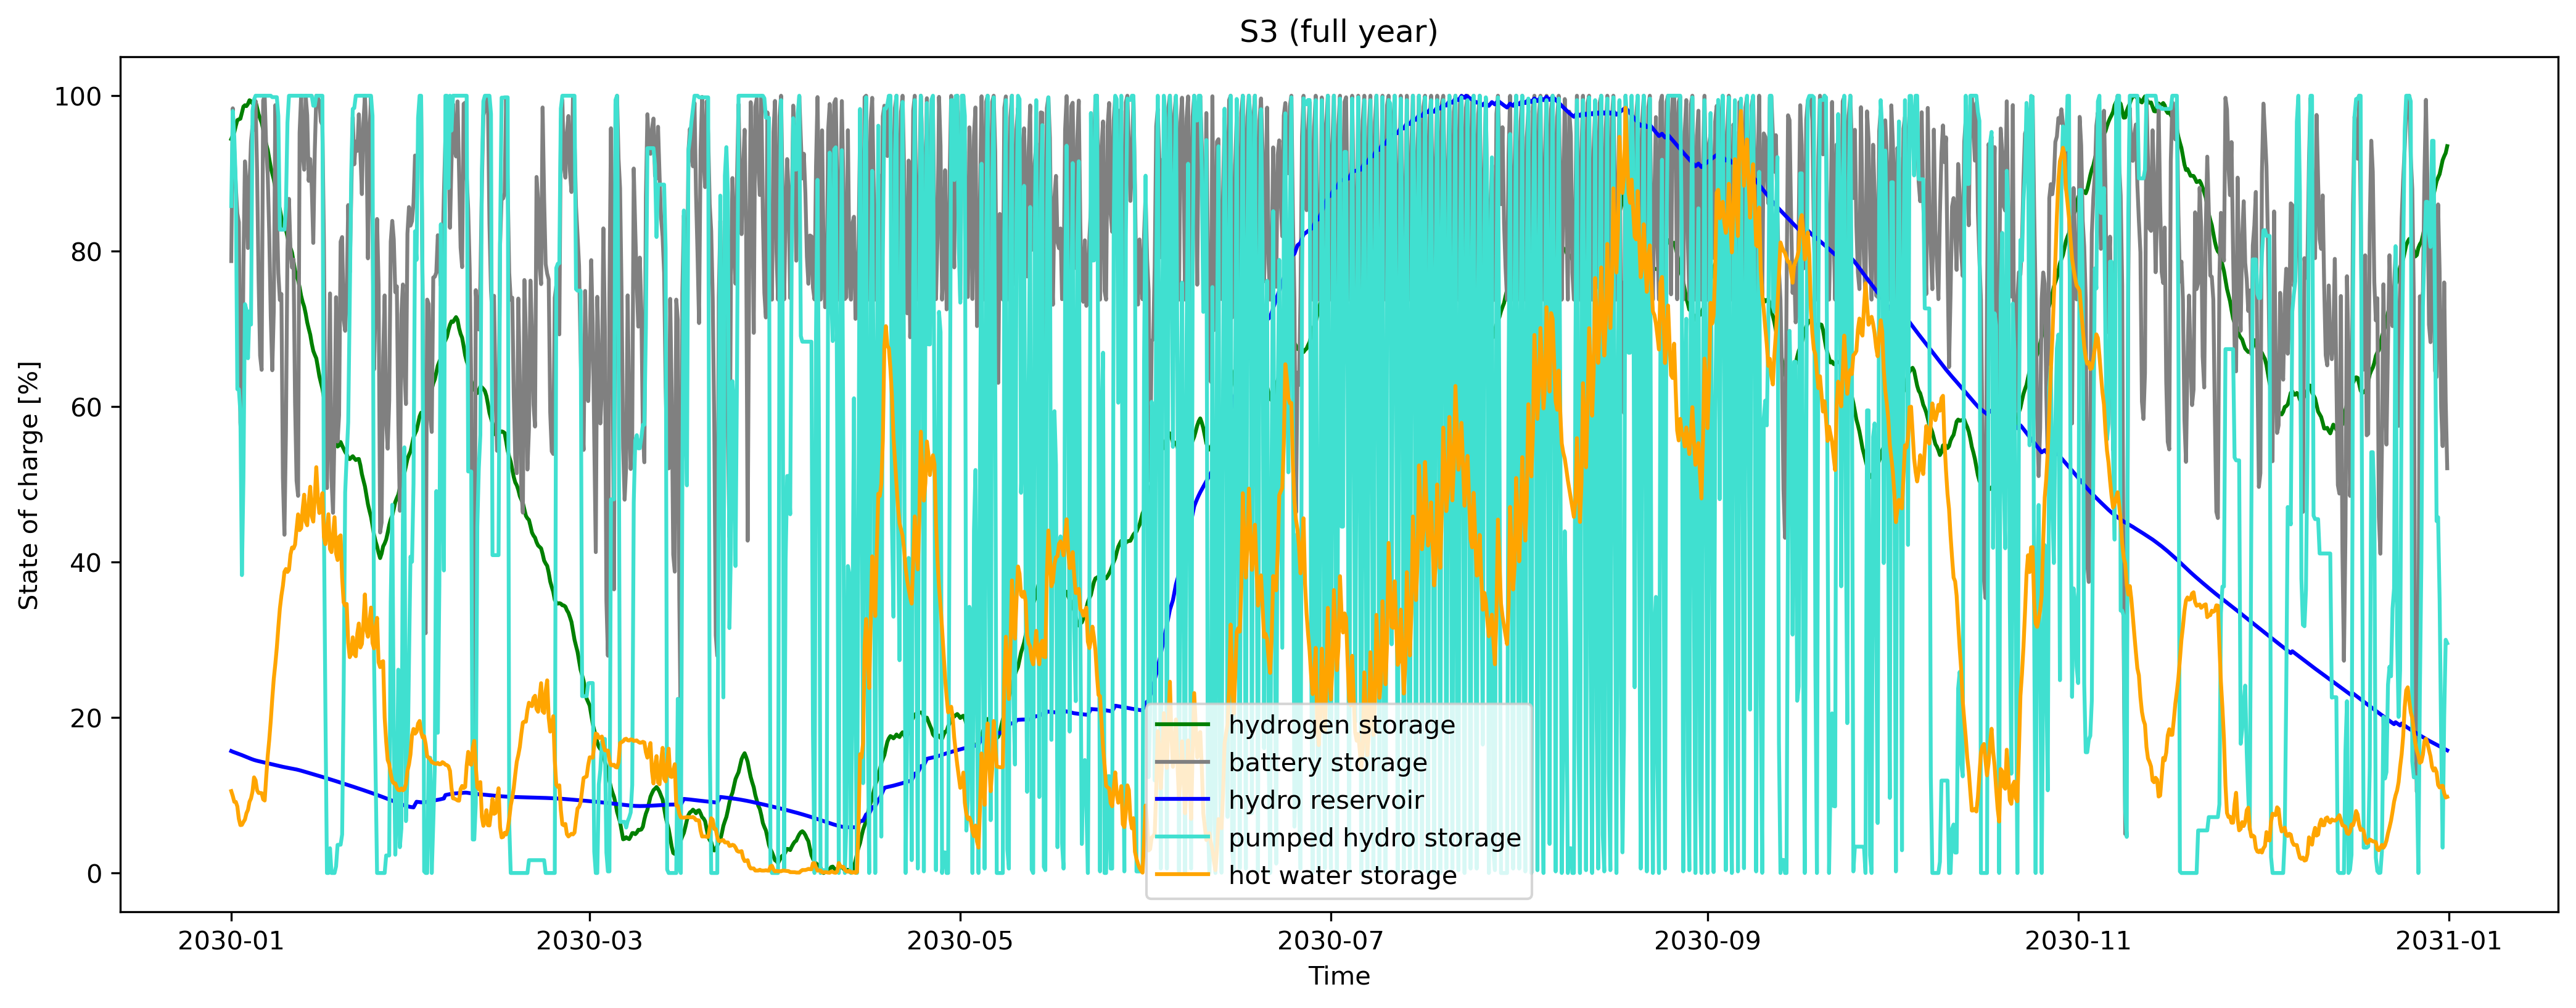

In [43]:
plt.figure(figsize=(17, 6),dpi=300)
plt.plot(ts2["h2 SOC [%]"], color="green", label="hydrogen storage")
plt.plot(ts2["battery SOC [%]"], color="grey", label="battery storage")
plt.plot(ts2["hydro SOC [%]"], color="blue", label="hydro reservoir")
plt.plot(ts2["PHS SOC [%]"], color="turquoise", label="pumped hydro storage")
plt.plot(ts2["hot water SOC [%]"], color="orange", label="hot water storage")
#plt.fill_between(ts2["deficit [GW]"].loc["2030-01"].index, ts2["load [GW]"].loc["2030-01"], ts2["RE"].loc["2030-01"], color="grey", label="deficit")
#plt.fill_between(ts2.index, ts2["load [TW]"].loc["2013-01"], ts2["RE"].loc["2013-01"], color="grey", label="deficit")

plt.xlabel("Time")
plt.ylabel("State of charge [%]")
plt.title("S3 (full year)")
plt.legend()
plt.show()

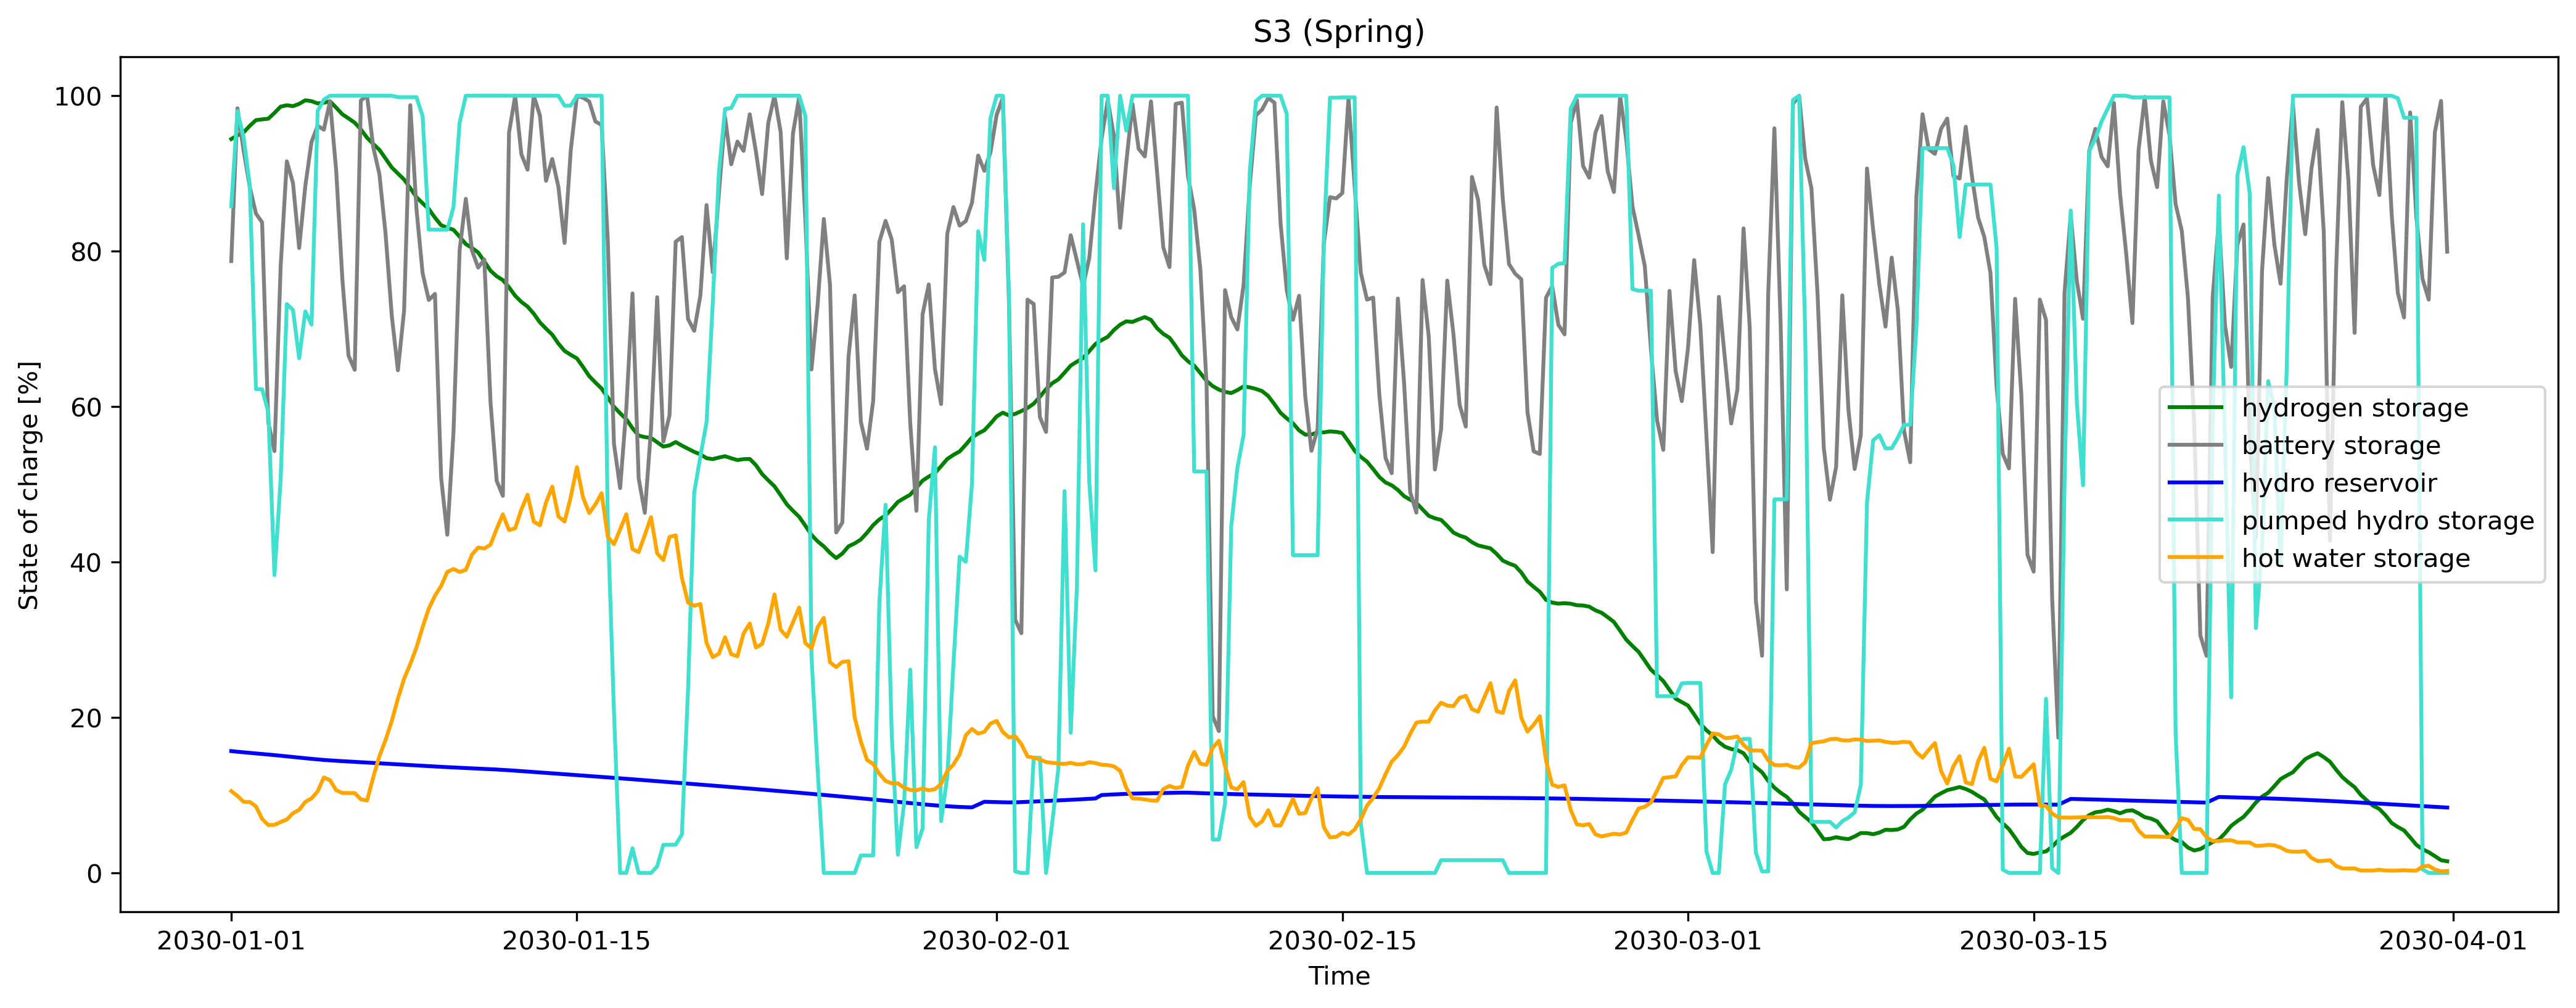

In [42]:
plt.figure(figsize=(17, 6),dpi=300)
plt.plot(ts2["h2 SOC [%]"].loc["2030-01":"2030-03"], color="green", label="hydrogen storage")
plt.plot(ts2["battery SOC [%]"].loc["2030-01":"2030-03"], color="grey", label="battery storage")
plt.plot(ts2["hydro SOC [%]"].loc["2030-01":"2030-03"], color="blue", label="hydro reservoir")
plt.plot(ts2["PHS SOC [%]"].loc["2030-01":"2030-03"], color="turquoise", label="pumped hydro storage")
plt.plot(ts2["hot water SOC [%]"].loc["2030-01":"2030-03"], color="orange", label="hot water storage")
#plt.fill_between(ts2["deficit [GW]"].loc["2030-01"].index, ts2["load [GW]"].loc["2030-01"], ts2["RE"].loc["2030-01"], color="grey", label="deficit")
#plt.fill_between(ts2.index, ts2["load [TW]"].loc["2013-01"], ts2["RE"].loc["2013-01"], color="grey", label="deficit")

plt.xlabel("Time")
plt.ylabel("State of charge [%]")
plt.title("S3 (Spring)")
plt.legend()
plt.show()

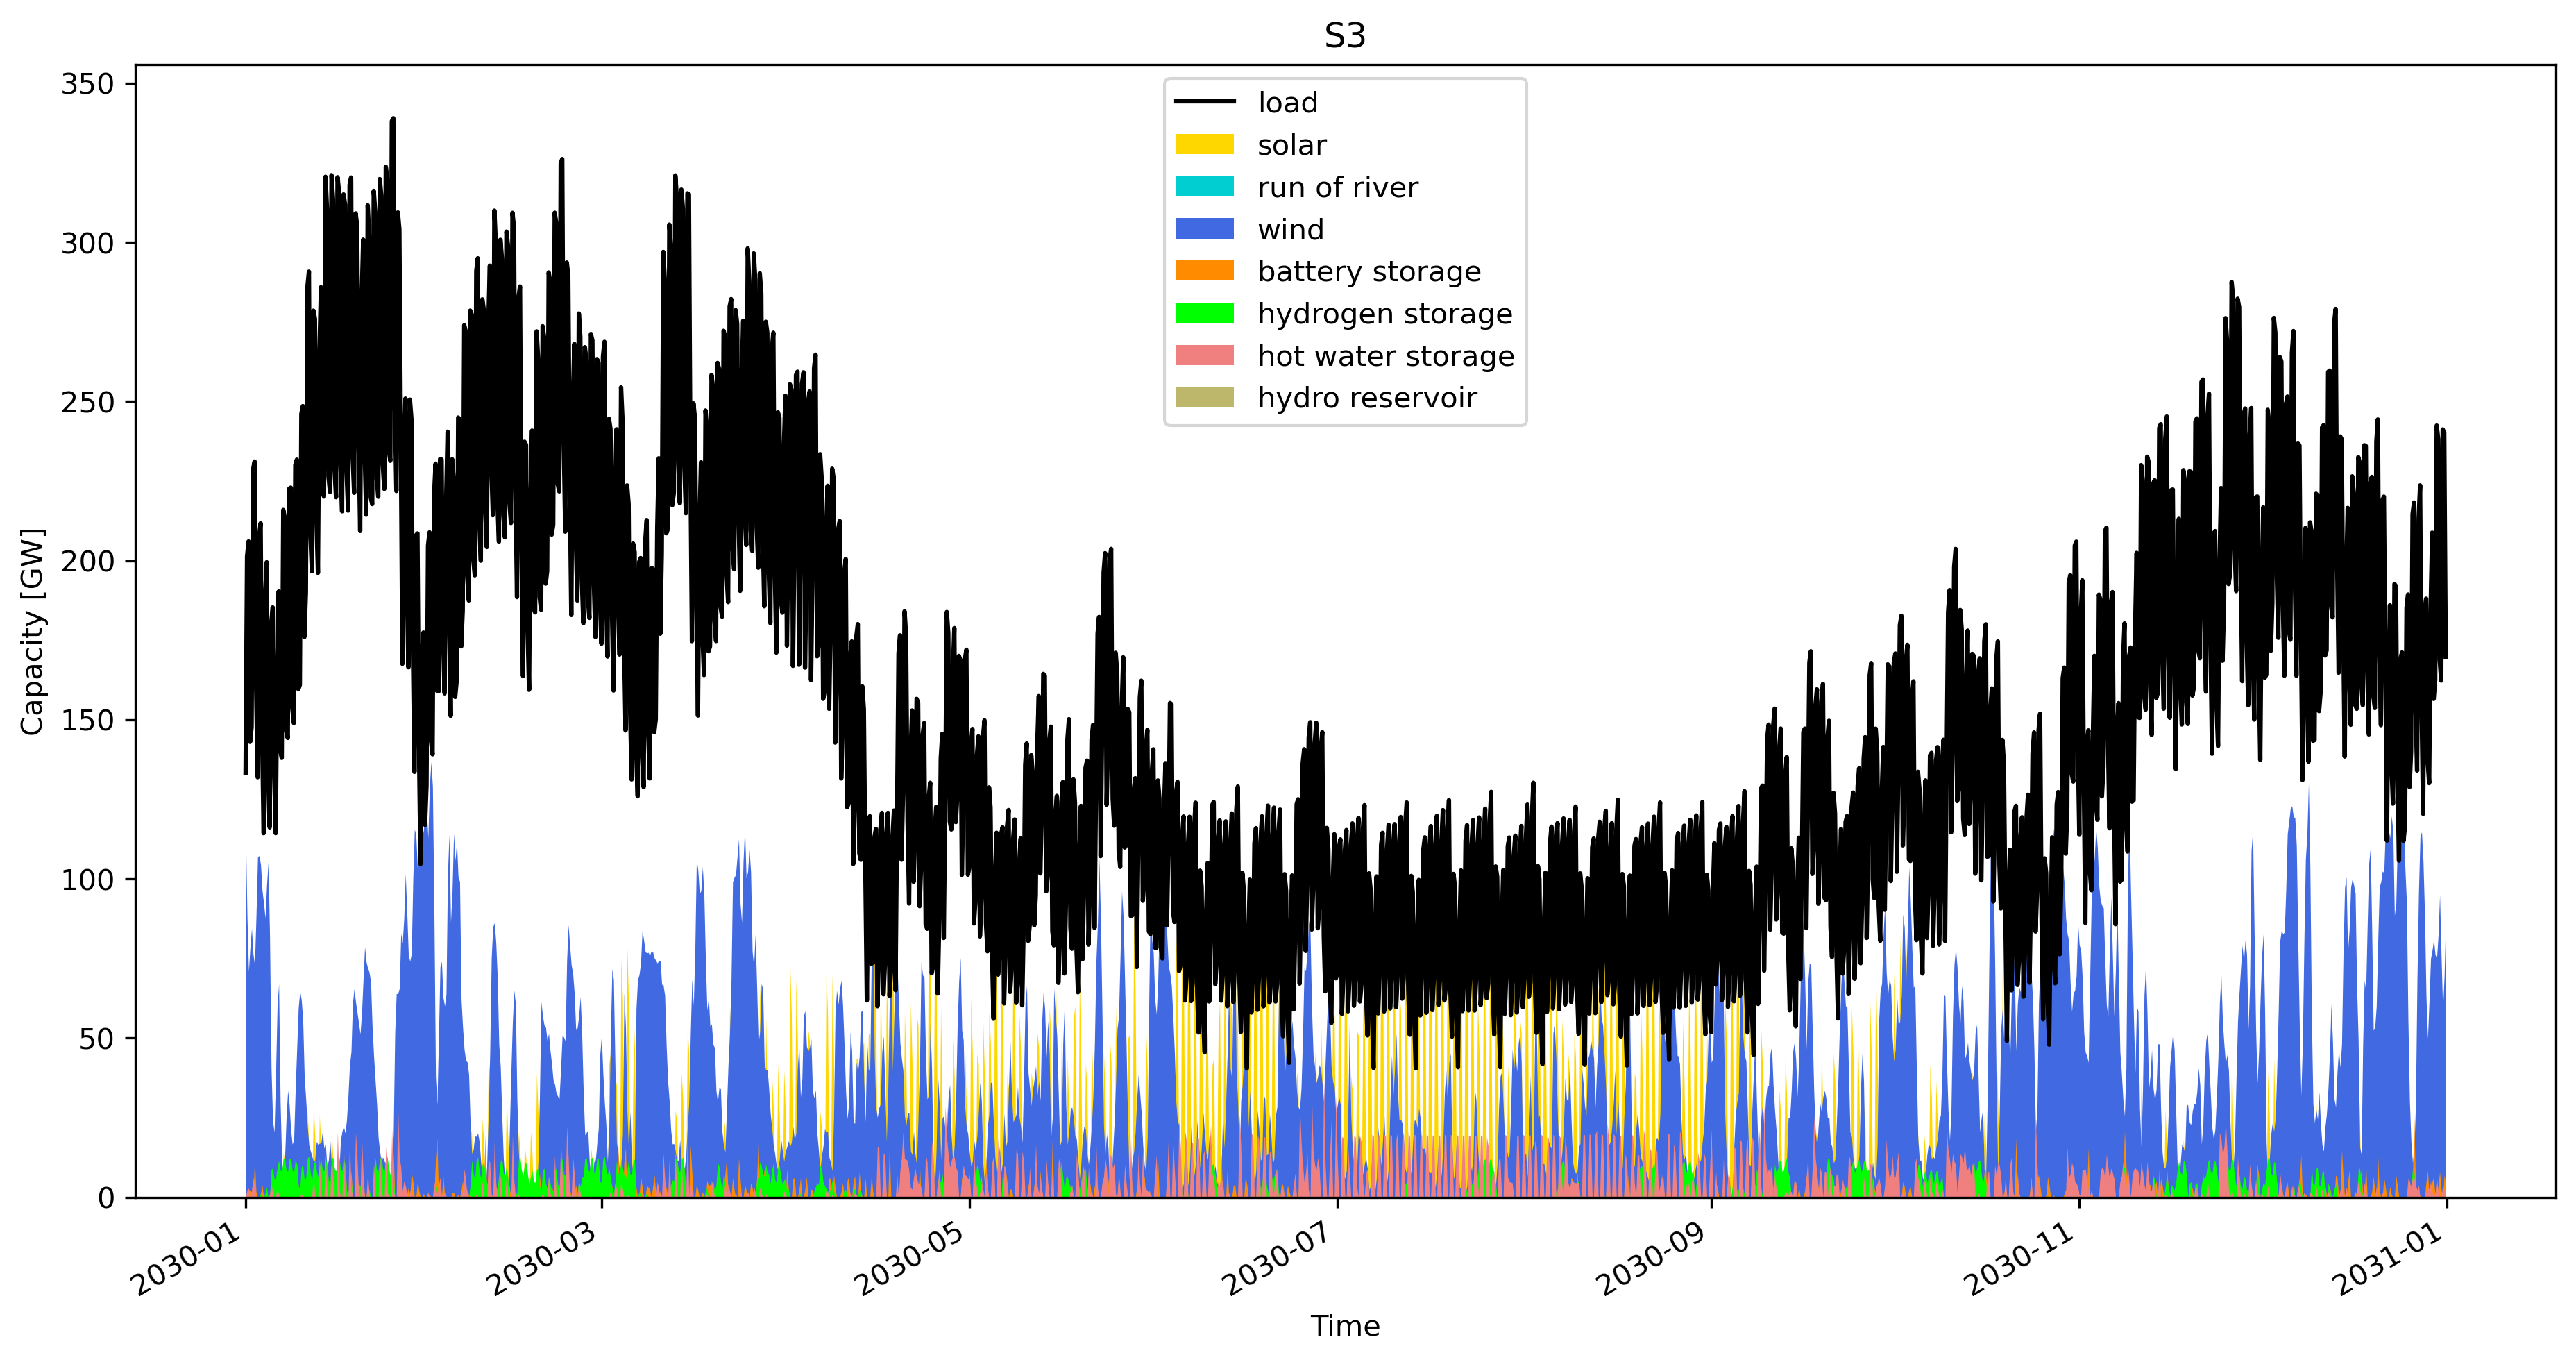

In [45]:
fig, ax = plt.subplots(figsize=(15, 8), dpi=300)
plt.plot(ts2["load [GW]"], color="black", label="load")
ts2["solar [GW]"].plot.area(ax=ax,linewidth=0,color="gold",label="solar")
ts2["ror [GW]"].plot.area(ax=ax,linewidth=0,color="darkturquoise",label="run of river")
ts2["wind [GW]"].plot.area(ax=ax,linewidth=0,color="royalblue",label="wind")
ts2["battery dispatch [GW]"].where(ts2["battery dispatch [GW]"]>0).plot.area(ax=ax,linewidth=0,color="darkorange",label="battery storage")
ts2["h2 dispatch [GW]"].where(ts2["h2 dispatch [GW]"]>0).plot.area(ax=ax,linewidth=0,color="lime",label="hydrogen storage")
ts2["hot water disptach [GW]"].where(ts2["hot water disptach [GW]"]>0).plot.area(ax=ax,linewidth=0,color="lightcoral",label="hot water storage")
ts2["hydro disptach [GW]"].where(ts2["hydro disptach [GW]"]>0).plot.area(ax=ax,linewidth=0,color="darkkhaki",label="hydro reservoir")
#ts2["PHS disptach [GW]"].where(ts2["PHS disptach [GW]"]>0).plot.area(ax=ax,linewidth=0,color="darkkhaki",label="pumped hydro storage")


#plt.plot(ts2["load [GW]"], color="black", label="load")

plt.xlabel("Time")
plt.ylabel("Capacity [GW]")
plt.title("S3")
plt.legend()
plt.show()

In [172]:
sab3 = n3.links_t.p0.filter(regex='^DE.*Sabatier$').sum(axis=1)
sab3.index = pd.to_datetime(sab3.index)
sab3.index = sab3.index.map(lambda dt: dt.replace(year=2030))
#pct3_home_battery = sab3/(0.638464)*100
#pct3_home_battery = pct3_home_battery.to_frame(name="FNB")
sab3.sum()

8.249221851979415

In [35]:
ft3 = n3.links_t.p0.filter(regex='^DE.*Fischer-Tropsch$').sum(axis=1) # MW
ft3.index = pd.to_datetime(ft3.index)
ft3.index = ft3.index.map(lambda dt: dt.replace(year=2030))
#pct3_home_battery = sab3/(0.638464)*100
#pct3_home_battery = pct3_home_battery.to_frame(name="FNB")
ft3.sum()

43.845032681535244

In [36]:
fc3 = n3.links_t.p0.filter(regex='^DE.*H2 Fuel Cell$').sum(axis=1) # MW
fc3.index = pd.to_datetime(fc3.index)
fc3.index = fc3.index.map(lambda dt: dt.replace(year=2030))
#pct3_home_battery = sab3/(0.638464)*100
#pct3_home_battery = pct3_home_battery.to_frame(name="FNB")
fc3.sum()

15.207741010658905

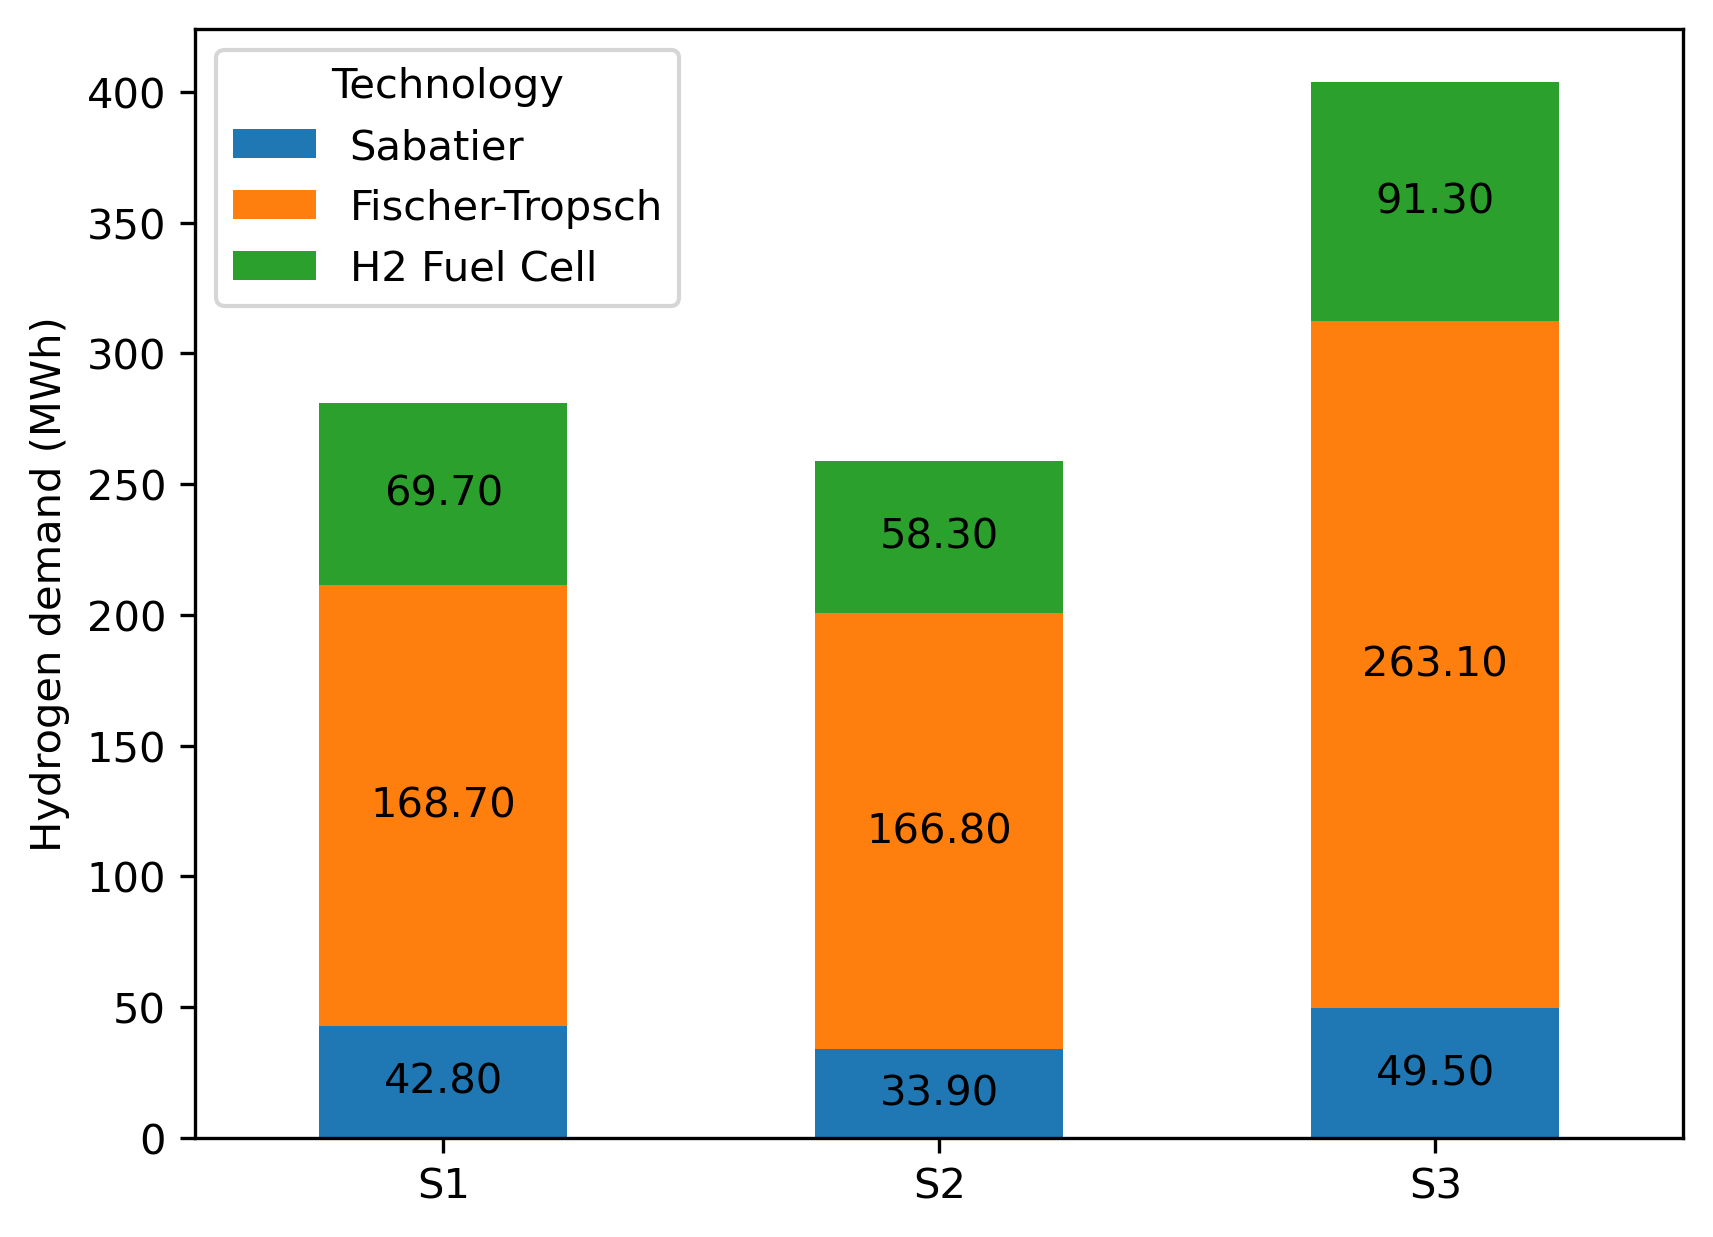

In [20]:
networks = ['S1', 'S2', 'S3']
technologies = ['Sabatier', 'Fischer-Tropsch', 'H2 Fuel Cell']
values = {
    'Sabatier': [42.8, 33.9, 49.5],
    'Fischer-Tropsch': [168.7, 166.8, 263.1],
    'H2 Fuel Cell': [69.7, 58.3, 91.3]
}

# Convert the values dictionary into a DataFrame
df = pd.DataFrame(values, index=networks)

# Plotting
fig, ax = plt.subplots(dpi=300)

# Create the stacked bar chart
df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xticklabels(networks, rotation=0)

# Annotate the demand capacities on the bars
for i, network in enumerate(networks):
    for j, tech in enumerate(technologies):
        value = df.loc[network, tech]
        ax.text(i, df.loc[network, :tech].sum() - (value / 2), f'{value:.2f}', ha='center', va='center')

# Add a legend
ax.legend(title='Technology')
plt.ylabel("Hydrogen demand (MWh)")

# Display the plot
plt.show()




In [7]:
mt3 = n3.links_t.p0.filter(regex='^DE.*methanolisation$').sum(axis=1) # MW
mt3.index = pd.to_datetime(fc3.index)
mt3.index = fc3.index.map(lambda dt: dt.replace(year=2030))

mt3.sum()

185.16686463930648